In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Homework1.ipynb")

# Stat 198: Introduction to Quantitative Finance DeCal

Stat 198 is hosted by [Traders at Berkeley](https://traders.berkeley.edu/). 

Course Website: [https://traders.berkeley.edu/education](https://traders.berkeley.edu/education.html)

# Homework #1

In this homework, we're going to test out a HFT latency arbitrage taker strategy similar to ones used at high frequency trading firms, using one asset to predict the movements of a similar, correlated one

**Learning Objectives:**

- Reconstruct an orderbook
- Implement a basic trade simulator given a hypothetical trade and orderbook data
- Create Book Pressure signals for the perp and spot asset
- Use the leading asset to predict the lagging asset and execute hypothetical trades


## Importing Libraries

In [2]:
from tardis_dev import datasets
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Importing Orderbook Data

In [3]:
import nest_asyncio

nest_asyncio.apply()
datasets.download(
    exchange="binance-futures",
    data_types=[
        "incremental_book_L2",
        #"trades",
        #"quotes",
        #"derivative_ticker",
        #"book_snapshot_25",
        #"liquidations"
    ],
    from_date=f"2023-02-01T00:00:00Z",
    to_date=f"2023-02-01T23:59:59Z",
    symbols=['BTCUSDT'],
    api_key='',
)

nest_asyncio.apply()
datasets.download(
    exchange="binance",
    data_types=[
        "incremental_book_L2",
        #"trades",
        #"quotes",
        #"derivative_ticker",
        #"book_snapshot_25",
        #"liquidations"
    ],
    from_date=f"2023-02-01T00:00:00Z",
    to_date=f"2023-02-01T23:59:59Z",
    symbols=['BTCUSDT'],
    api_key='',
)

nest_asyncio.apply()
datasets.download(
    exchange="binance-futures",
    data_types=[
        #"incremental_book_L2",
        #"trades",
        "quotes",
        #"derivative_ticker",
        #"book_snapshot_25",
        #"liquidations"
    ],
    from_date=f"2023-02-01T00:00:00Z",
    to_date=f"2023-02-01T23:59:59Z",
    symbols=['BTCUSDT'],
    api_key='',
)

nest_asyncio.apply()
datasets.download(
    exchange="binance",
    data_types=[
        #"incremental_book_L2",
        #"trades",
        "quotes",
        #"derivative_ticker",
        #"book_snapshot_25",
        #"liquidations"
    ],
    from_date=f"2023-02-01T00:00:00Z",
    to_date=f"2023-02-01T23:59:59Z",
    symbols=['BTCUSDT'],
    api_key='',
)

fname_spotquotes = 'binance_quotes_2023-02-01_BTCUSDT.csv.gz'
fname_perpquotes = 'binance-futures_quotes_2023-02-01_BTCUSDT.csv.gz'
fname_perp = 'binance-futures_incremental_book_L2_2023-02-01_BTCUSDT.csv.gz'
fname_spot = 'binance_incremental_book_L2_2023-02-01_BTCUSDT.csv.gz'

## Read In Data

this should take a while do not worry

In [4]:
perpbook = pd.read_csv(f'datasets/{fname_perp}', compression='gzip')
spotbook = pd.read_csv(f'datasets/{fname_spot}', compression='gzip')

In [5]:
perpquotes = pd.read_csv(f'datasets/{fname_perpquotes}', compression='gzip')
spotquotes = pd.read_csv(f'datasets/{fname_spotquotes}', compression='gzip')

## Q1: Reconstruct Orderbook at Given Time

Given an initial snapshot of the state of an orderbook at midnight, and all of its following updates, reconstruct a snapshot of the book at a given timestamp.

Assume that you are given a valid timestamp

Your function should return a dataframe representing all price levels with a nonzero quantity at each level.

In [6]:
spotbook

,exchange,symbol,timestamp,local_timestamp,is_snapshot,side,price,amount
0,binance,BTCUSDT,1675209602162275,1675209602162275,True,ask,23127.11,0.00000
1,binance,BTCUSDT,1675209602162275,1675209602162275,True,ask,23127.12,0.00000
2,binance,BTCUSDT,1675209602162275,1675209602162275,True,ask,23127.23,0.02709
3,binance,BTCUSDT,1675209602162275,1675209602162275,True,ask,23127.70,0.00000
4,binance,BTCUSDT,1675209602162275,1675209602162275,True,ask,23127.71,0.00000
...,...,...,...,...,...,...,...,...
55957040,binance,BTCUSDT,1675295999946000,1675295999949158,False,bid,23725.47,0.05199
55957041,binance,BTCUSDT,1675295999946000,1675295999949158,False,bid,23720.63,0.00773
55957042,binance,BTCUSDT,1675295999946000,1675295999949158,False,bid,23718.35,0.05199
55957043,binance,BTCUSDT,1675295999946000,1675295999949158,False,bid,22550.00,11.05615


In [7]:

#autograder code
def bookstate(book, snaptime):
    snapts = pd.to_datetime(snaptime).timestamp()*1000000
    if snapts < book['timestamp'].values[0]:
        snapts = book['timestamp'].values[0]
    book = book[book['timestamp'] <= snapts]
    book = book.sort_values(['price', 'timestamp'], ascending=False).groupby('price').head(1)
    # note that groupby.head preserves the index of the initial dataframe, and results in unintended behavior
    book = book[book['amount'] > 0.00]
    
    return book
    
bookstate(spotbook, 1675209602162275)

,exchange,symbol,timestamp,local_timestamp,is_snapshot,side,price,amount
1076,binance,BTCUSDT,1675209602162275,1675209602162275,True,ask,23535.00,0.17112
1030,binance,BTCUSDT,1675209602162275,1675209602162275,True,ask,23300.69,0.00497
999,binance,BTCUSDT,1675209602162275,1675209602162275,True,ask,23186.92,0.02546
998,binance,BTCUSDT,1675209602162275,1675209602162275,True,ask,23186.89,0.00075
997,binance,BTCUSDT,1675209602162275,1675209602162275,True,ask,23186.88,0.00067
...,...,...,...,...,...,...,...,...
2110,binance,BTCUSDT,1675209602162275,1675209602162275,True,bid,22671.10,0.00048
2154,binance,BTCUSDT,1675209602162275,1675209602162275,True,bid,21500.00,177.17283
2089,binance,BTCUSDT,1675209602162275,1675209602162275,True,bid,20888.00,27.42850
2182,binance,BTCUSDT,1675209602162275,1675209602162275,True,bid,11563.19,0.00103


In [8]:
grader.check("q1")

q1 results: All test cases passed!

## Q2: Trade Simulator

Now that we have a snapshot of an orderbook, let's see if we can simulate what would happen to that orderbook if we were to execute a trade

Given a notional size to trade (asset amount in USD value) and a theoretical value: return the average fill price of the trade, and the quantity transacted. 

Assume that you have no market impact, and that the book remains the same until your order is filled (add a written q later, smth like: is this a fair assumption?)

(Should you trade at your theoretical value?)

In [9]:
def trade_simulator(state, tradeside='ask', tradesize=10000, theoreticalvalue=0):
    
    isAsk = tradeside == 'ask'
    state = state[state['side'] == tradeside].sort_values(by = 'price', ascending = isAsk)
    state = state[state['amount'] > 0]
    prices = state['price']
    amounts = state['amount']
    size_hit = 0
    total_spend = 0
    
    for p, a in zip(prices, amounts):
        if ((tradeside == 'ask' and p >= theoreticalvalue) or  (tradeside == 'bid' and p <= theoreticalvalue)):
            break
        if (total_spend + (p * a) > tradesize):
            break
        else:
            size_hit += a
            total_spend += p * a
            

    average_fill = 0
    if (size_hit != 0):
        average_fill = total_spend / size_hit
    

    return [average_fill, total_spend]



In [10]:
trade_simulator(bookstate(perpbook, 1675227824977135), tradeside='ask', tradesize=180000, theoreticalvalue=23120)[1]
print('desire', 170922.53069999997)

desire 170922.53069999997


In [11]:
grader.check("q2")

q2 results: All test cases passed!

## Book Pressure Signal Explanation

Consider an orderbook that looks like the following

    Bid Qty  |  Price  |  Offer Qty


             |   104   |   370   
             |   103   |   200   
      100    |   102   |         
      150    |   101   |         

Would the book tick up first? Or down first?

What might we think the theoretical 'fair' price is in this market?

The first observation we might make is that there's more (twice as much) demand at the best offer than at the best bid. 

If we assume that market buys and market sells arrive roughly with even probability/size, then we'd expect that the best bid would be exhausted before the best offer twice as often than the best offer would be exhausted before the best bid

**Book Pressure** is our expected future fair value derived from this assumption. 

We can derive the book pressure using this example.

We expect that the best bid gets exhausted 2/3 of the time as often as the best offer, so we can write

$\text{E(future price)} = \text{P}(\text{best bid exhausted}) * \text{best bid price} + \text{P}(\text{best ask exhaused}) *\text{best ask price}$

$2/3 * (102) + 1/3 * (103)$

$204/3 + 103/3$

$307/3$

$102.3333$

The more traditional representation of the formula is as follows:

$\dfrac{\text{(best bid qty * best offer price) + (best offer qty * best bid price)}}{\text{best bid qty + best offer qty}}$

Plugging in our values from the sample orderbook above, we double check that

$\dfrac{(100 * 103) + (200 * 102)}{{100 + 200}}$

$\dfrac{(10300) + (20400)}{{300}}$

$\dfrac{(30700)}{{300}}$

$102.3333$

## Q3: Book Pressure Signal Implementation

Please implement the above formula using the provided quotes dataframe that provides the amounts and price of the best bid and offer

In [12]:
spotquotes.head()

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount
0,binance,BTCUSDT,1675209602162275,1675209602162275,0.00066,23126.52,23126.20,0.03000
1,binance,BTCUSDT,1675209602181000,1675209602186622,0.04320,23127.58,23126.11,0.05807
2,binance,BTCUSDT,1675209602281000,1675209602284878,0.00108,23127.57,23126.67,0.03703
3,binance,BTCUSDT,1675209602382000,1675209602386776,0.02709,23127.58,23126.75,0.05807
4,binance,BTCUSDT,1675209602482000,1675209602489723,0.06238,23127.50,23126.60,0.05807


In [13]:
perpquotes.head()

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount
0,binance-futures,BTCUSDT,1675209600232000,1675209600938091,6.736,23119.5,23119.4,11.939
1,binance-futures,BTCUSDT,1675209602110000,1675209602113182,6.736,23119.5,23119.4,12.289
2,binance-futures,BTCUSDT,1675209604939000,1675209604942416,6.736,23119.5,23119.4,12.290
3,binance-futures,BTCUSDT,1675209605208000,1675209605210812,6.734,23119.5,23119.4,12.290
4,binance-futures,BTCUSDT,1675209606571000,1675209606576664,6.826,23119.5,23119.4,12.263


In [14]:

def bookpressure(quotes):
    quotes['bookpressure'] = (quotes['ask_amount'] 
                              * quotes['bid_price'] + 
                              quotes['bid_amount'] 
                              * quotes['ask_price'])/(quotes['ask_amount'] 
                                                      + quotes['bid_amount'])
    return quotes
    

In [15]:
grader.check("q3")

q3 results: All test cases passed!

feel free to play with the below function to visualize the best bid, best offer, and book pressure for the perp and spot books

<AxesSubplot: xlabel='timestamp'>

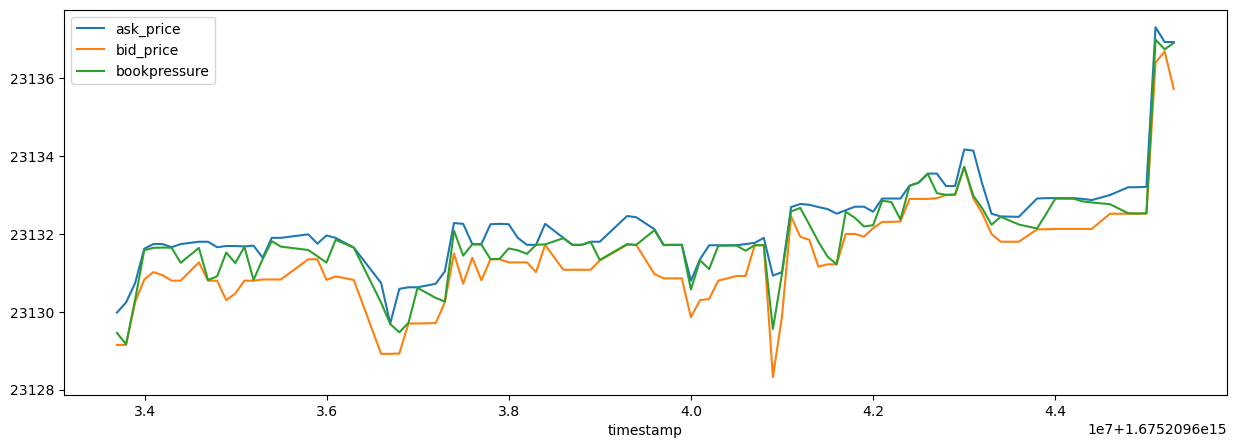

In [16]:
bookpressure(spotquotes).iloc[300:400,:].set_index('timestamp')[['ask_price', 'bid_price', 'bookpressure']].plot(figsize=(15,5))

<AxesSubplot: xlabel='timestamp'>

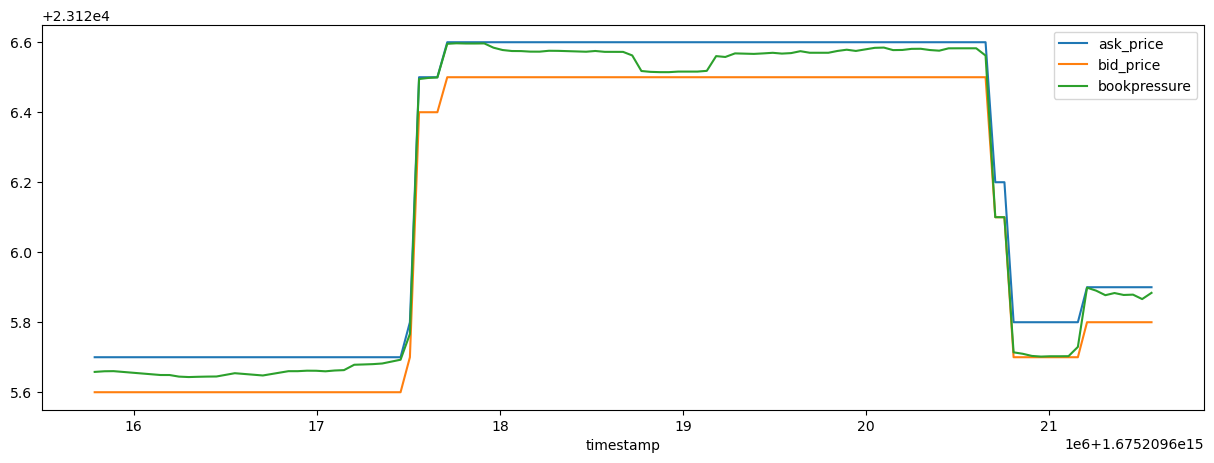

In [17]:
bookpressure(perpquotes).iloc[300:400,:].set_index('timestamp')[['ask_price', 'bid_price', 'bookpressure']].plot(figsize=(15,5))

## Q4: Latency Arb

The Spot BTC and the Perpetual BTC contract should, in theory, be the same price. However, markets are not usually so simple. 

Imagine that both assets are trading at 22k. Also assume that an informed trader on the perpetual exchange wants to buy a ton of BTC. 

When she executes the trade, lets pretend that it makes the Perpetual BTC Contract's price move up from 22k to 22.2k. 

The Perpetual Contract and the Spot BTC both represent the same asset - but their prices are out of whack. 

Fast traders can take advantage of this momentary dislocation in price, and help re-price the Spot market to the correct price of 22.2k, receiving a profit for this noble service. 

That's the basic idea behind a latency-based taker strategy, which we will implement a toy example of below

Generally speaking, we expect the perpetual futures market to lead the spot market

This means that when the perpetual moves, the spot market usually follows, instead of the other way around. 

Given this idea, please implement a trading strategy that takes positions based on dislocations in spot and perp BTC pricing.

Your goal should be to produce conditions that define when a trading strategy should enter a position, and how much time it should hold the position for

Assume no fees, for simplicity. 

A trade executed can, at most, consume the remaining liquidity available at the best bid or best offer.

Assume that you can always exit for your added size 

For example, if your strategy is meant to add long exposure, the maximum long exposure it can add is the ask amount available at the time

In [17]:
bpspot = bookpressure(spotquotes).set_index('timestamp')
bpperp = bookpressure(perpquotes).set_index('timestamp')
combinedbp = bpperp.join(bpspot, lsuffix='_perp', rsuffix='_spot')
combinedbp[['ask_amount_spot', 'ask_price_spot', 'bid_price_spot', 'bid_amount_spot', 'bookpressure_spot']] = combinedbp[['ask_amount_spot', 'ask_price_spot', 'bid_price_spot', 'bid_amount_spot', 'bookpressure_spot']].ffill()
combinedbp[['ask_amount_spot', 'ask_price_spot', 'bid_price_spot', 'bid_amount_spot', 'bookpressure_spot']] = combinedbp[['ask_amount_spot', 'ask_price_spot', 'bid_price_spot', 'bid_amount_spot', 'bookpressure_spot']].bfill()
combinedbp['bookpressure_spot'].ffill(inplace=True)
combinedbp['bookpressure_spot'].bfill(inplace=True)
combinedbp['bookpressure_perp'].ffill(inplace=True)

In [18]:
def strategy(combinedbp, buycondition, sellcondition, holdtime, cost=0):
    combinedbp['profit'] = 0
    combinedbp['cost'] = 0
    combinedbp[f'ask_amount_spot_{holdtime}'] = combinedbp['ask_amount_spot'].shift(-holdtime)
    combinedbp[f'bid_amount_spot_{holdtime}'] = combinedbp['bid_amount_spot'].shift(-holdtime)
    combinedbp[f'ask_price_spot_{holdtime}'] = combinedbp[f'ask_price_spot'].shift(-holdtime)
    combinedbp[f'bid_price_spot_{holdtime}'] = combinedbp[f'ask_price_spot'].shift(-holdtime)
    buys = combinedbp[buycondition]
    buys['profit'] = (buys['ask_price_spot'] - buys[f'bid_price_spot_{holdtime}']) * buys['ask_amount_spot']
    plt.plot(buys['profit'])
    buys['cost'] = (cost * buys['bid_amount_spot'])
    sells = combinedbp[sellcondition]
    sells['profit'] = (sells['bid_price_spot'] - sells[f'ask_price_spot_{holdtime}']) * sells['bid_amount_spot'] 
    sells['cost'] = (cost * sells['ask_amount_spot'])
    plt.plot(sells['profit'])
    
    return sells['profit'].fillna(0).sum() + buys['profit'].fillna(0).sum() - buys['cost'].fillna(0).sum() -  sells['cost'].fillna(0).sum()

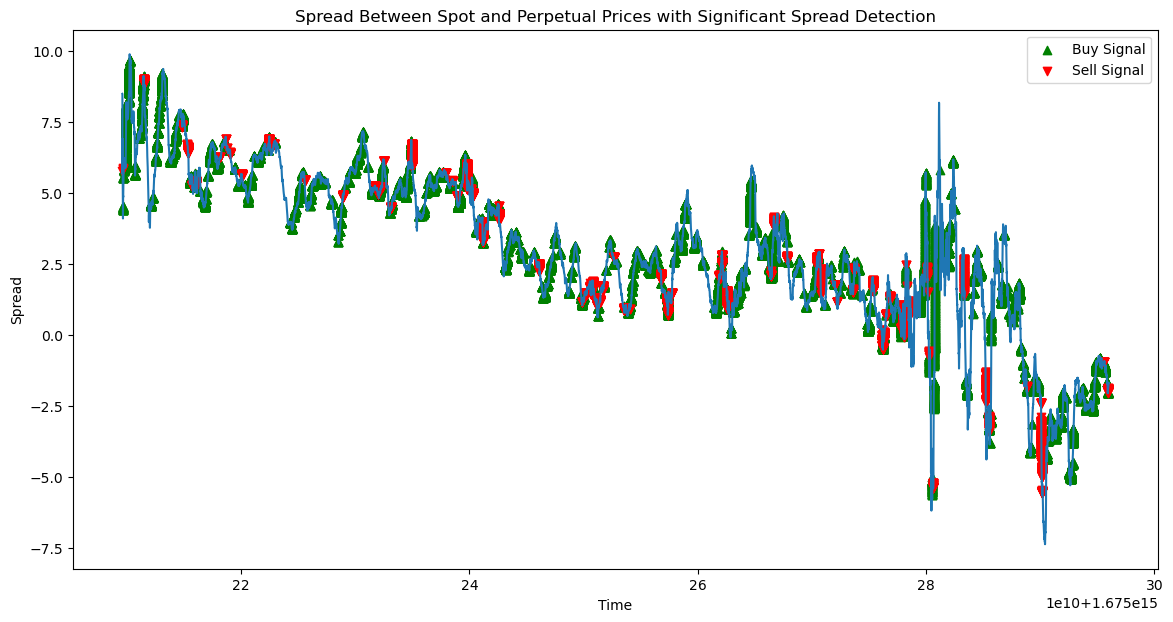

In [25]:
def alternate_buy_signal(window_size):
    
    combinedbp['spread'] = combinedbp['bookpressure_spot'] - combinedbp['bookpressure_perp']
    combinedbp['average_spread'] = combinedbp['spread'].rolling(window=10000, min_periods=1).mean()
    combinedbp['spread_std'] = combinedbp['spread'].rolling(window=10000, min_periods=1).std()
    
    
    
    combinedbp['average_spread_long'] = combinedbp['spread'].rolling(window=50000, min_periods=1).mean()
    combinedbp['spread_std_long'] = combinedbp['spread'].rolling(window=50000, min_periods=1).std()
    
    threshold_multiplier = 2  # This can be fine-tuned
    threshold_multiplier_low = 4
    combinedbp['upper_threshold'] = combinedbp['average_spread'] + (threshold_multiplier * combinedbp['spread_std'])
    combinedbp['lower_threshold'] = combinedbp['average_spread_long'] - (threshold_multiplier_low * combinedbp['spread_std_long'])
    
    # 5. Generate Buy Signals when Spread is Significantly Wider than Usual
    combinedbp['buy_signal'] = combinedbp['spread'] > combinedbp['upper_threshold']
    combinedbp['sell_signal'] = combinedbp['spread'] < combinedbp['lower_threshold']

    # Plotting the Spread and Thresholds
    plt.figure(figsize=(14, 7))
    plt.plot(combinedbp['average_spread'])
    plt.scatter(combinedbp.index[combinedbp['buy_signal']], combinedbp['average_spread'][combinedbp['buy_signal']], color='green', label='Buy Signal', marker='^')
    plt.scatter(combinedbp.index[combinedbp['sell_signal']], combinedbp['average_spread'][combinedbp['sell_signal']], color='red', label='Sell Signal', marker='v')
    plt.title('Spread Between Spot and Perpetual Prices with Significant Spread Detection')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.legend()
    plt.show()
    
alternate_buy_signal(10000)

12181.334439599948

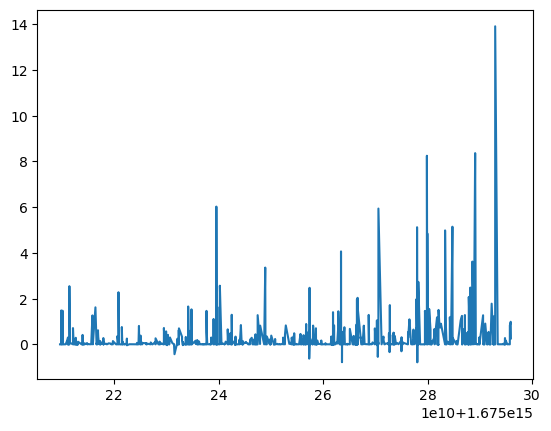

In [26]:

buycondition = combinedbp['buy_signal']
sellcondition = np.zeros(len(combinedbp), dtype=bool) 
strategy(combinedbp, buycondition, sellcondition, holdtime=80, cost=0)

q4 results: All test cases passed!

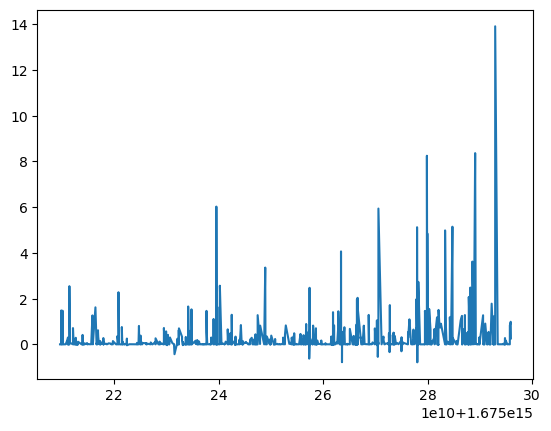

In [27]:
grader.check("q4")

## Assumptions Made in this Homework

In the cell below, please make a list of all assumptions made by the provided code in this homework.
For example, there are multiple assumptions made in the backtester that make the simulation very far from reality. 
Can you find them?

- Our trades will impact the market and pricing, so we can't always have this liquidity since the market will react to our participation 
- In reality having futures and spot data at the same time is quite difficult and others will be trying to do the same thing 
- our model assumes no execution or counterparty risk when in reality these risks exists and trades may not always be executed in the way in which we want them to be.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [28]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...



KeyboardInterrupt: 